In [1]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

# Dimensionally, Spatially adaptive sparse grid.

https://sgpp.sparsegrids.org/docs/example_predictiveRefinement_py.html

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# Copyright (C) 2008-today The SG++ project
# This file is part of the SG++ project. For conditions of distribution and
# use, please see the copyright notice provided with SG++ or at
# sgpp.sparsegrids.org




## \page example_predictiveRefinement_py Spatially-Dimension-Adaptive Refinement in Python
## 
## 
## We compute the sparse grid interpolant of the function \f$ f(x) =
## \sin(\pi x).\f$ We perform spatially-dimension-adaptive
## refinement of the sparse grid model, which means we refine a
## particular grid point (locality) only in some dimensions
## (dimensionality).
## 
## For details on spatially-dimension-adaptive refinement see
## \verbatim
##  V. Khakhutskyy and M. Hegland: Spatially-Dimension-Adaptive Sparse Grids for Online Learning.
##  Pflüger and J. Garcke (ed.), Sparse Grids and Applications - Stuttgart 2014, Volume 109 of LNCSE, p. 133–162. Springer International Publishing, March 2016.
## \endverbatim
## 
## 
## 
## The example can be found in the file `predictiveRefinement.py`.



# import modules
import sys
import math

from pysgpp import *



## Spatially-dimension-adaptive refinement uses squared prediction
## error on a dataset to compute refinement indicators. Hence, here
## we define a function to compute these squared errors.

def calculateError(dataSet,f,grid,alpha,error):
    print("calculating error")
    #traverse dataSet
    vec = DataVector(2)
    opEval = createOperationEval(grid)
    for i in range(dataSet.getNrows()):
        dataSet.getRow(i,vec)
        true = f(dataSet.get(i,0),dataSet.get(i,1))
        infered = opEval.eval(alpha,vec)
        print('true', true)
        print('infered', infered)
        error[i] = pow(true-infered,2)
    return error


## We define the function \f$ f(x) =
## \sin(\pi x).\f$ to interpolate.
# f = lambda x0, x1: math.sin(x0*math.pi)

from non_smooth_test_functions import cosineMixture
f = lambda x0, x1: cosineMixture([x0, x1])

## Create a two-dimensional piecewise bi-linear grid
dim = 2
grid = Grid.createModLinearGrid(dim)
HashGridStorage = grid.getStorage()
print("dimensionality:                   {}".format(dim))

# create regular grid, level 3
level = 7
gridGen = grid.getGenerator()
gridGen.regular(level)
print("number of initial grid points:    {}".format(HashGridStorage.getSize()))

## To create a dataset we use points on a regular 2d grid with a
## step size of 1 / rows and 1 / cols.

rows = 100
cols = 100

dataSet = DataMatrix(rows*cols,dim)
vals = DataVector(rows*cols)

for i in range(rows):
    for j in range(cols):
        #xcoord
        dataSet.set(i*cols+j,0,i*1.0/rows)
        #ycoord
        dataSet.set(i*cols+j,1,j*1.0/cols)
        vals[i*cols+j] = f(i*1.0/rows,j*1.0/cols)


## We refine adaptively 20 times. In every step we recompute the
## vector of surpluses `alpha`, the vector with squared errors on
## the dataset `errorVector`, and then call the refinement
## routines.
##  

# create coefficient vectors
alpha = DataVector(HashGridStorage.getSize())
print("length of alpha vector:           {}".format(alpha.getSize()))

# now refine adaptively 20 times
for refnum in range(10):

    
    ## Step 1: calculate the surplus vector alpha. In data
    ## mining with do it by solving a regression problem.
    ## Here, the function can be evaluated at any point. Hence. we
    ## simply evaluate it at the coordinates of the grid points to
    ## obtain the nodal values. Then we use hierarchization to
    ## obtain the surplus value.
    for i in range(HashGridStorage.getSize()):
        gp = HashGridStorage.getPoint(i)
        alpha[i] = f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1))

    # hierarchize
    createOperationHierarchisation(grid).doHierarchisation(alpha)
    
    
    ## Step 2: calculate squared errors.
    errorVector = DataVector(dataSet.getNrows())
    calculateError(dataSet, f, grid, alpha, errorVector)

    
    ## Step 3: call refinement routines. `PredictiveRefinement`
    ## implements the decorator pattern and extends the
    ## functionality of `HashRefinement`. `PredictiveRefinement`
    ## requires a special kind of refinement functor --
    ## `PredictiveRefinementIndicator` that can access the dataset
    ## and the error vector. The refinement itself if performed by
    ## calling `.free_refine()` same for normal refinement in
    ## `HashRefinement`.
    
    #refinement  stuff
    refinement = HashRefinement()
    decorator = PredictiveRefinement(refinement)
    # refine a single grid point each time
    print("Error over all = %s" % errorVector.sum())
    indicator = PredictiveRefinementIndicator(grid,dataSet,errorVector,1)
    decorator.free_refine(HashGridStorage,indicator)

    print("Refinement step %d, new grid size: %d" % (refnum+1, HashGridStorage.getSize()))

    # extend alpha vector (new entries uninitialized)
    alpha.resizeZero(HashGridStorage.getSize())

dimensionality:                   2
number of initial grid points:    769
length of alpha vector:           769
calculating error
true 0.09999999999999998
infered 0.09725857742442531
true 0.10113116594048621
infered 0.09989758244415864
true 0.1044943483704846
infered 0.10328527777440726
true 0.1099993475811632
infered 0.10871181460059487
true 0.11749830056250524
infered 0.11618396633811388
true 0.12678932188134523
infered 0.12553065903526422
true 0.13762147477075268
infered 0.13633570064235886
true 0.14970095002604533
infered 0.14834197638329208
true 0.16269830056250525
infered 0.16135609727813885
true 0.1762565534959769
infered 0.1749003035125456
true 0.18999999999999997
infered 0.18862247856245434
true 0.20354344650402306
infered 0.20215770223440505
true 0.21650169943749473
infered 0.21506144625574916
true 0.22849904997395465
infered 0.2270373140800619
true 0.2391785252292473
infered 0.23777231807585458
true 0.24821067811865474
infered 0.24674297573343262
true 0.2553016994374947
infe

length of alpha vector:           789
<class 'pysgpp.pysgpp_swig.DataVector'>
789
789


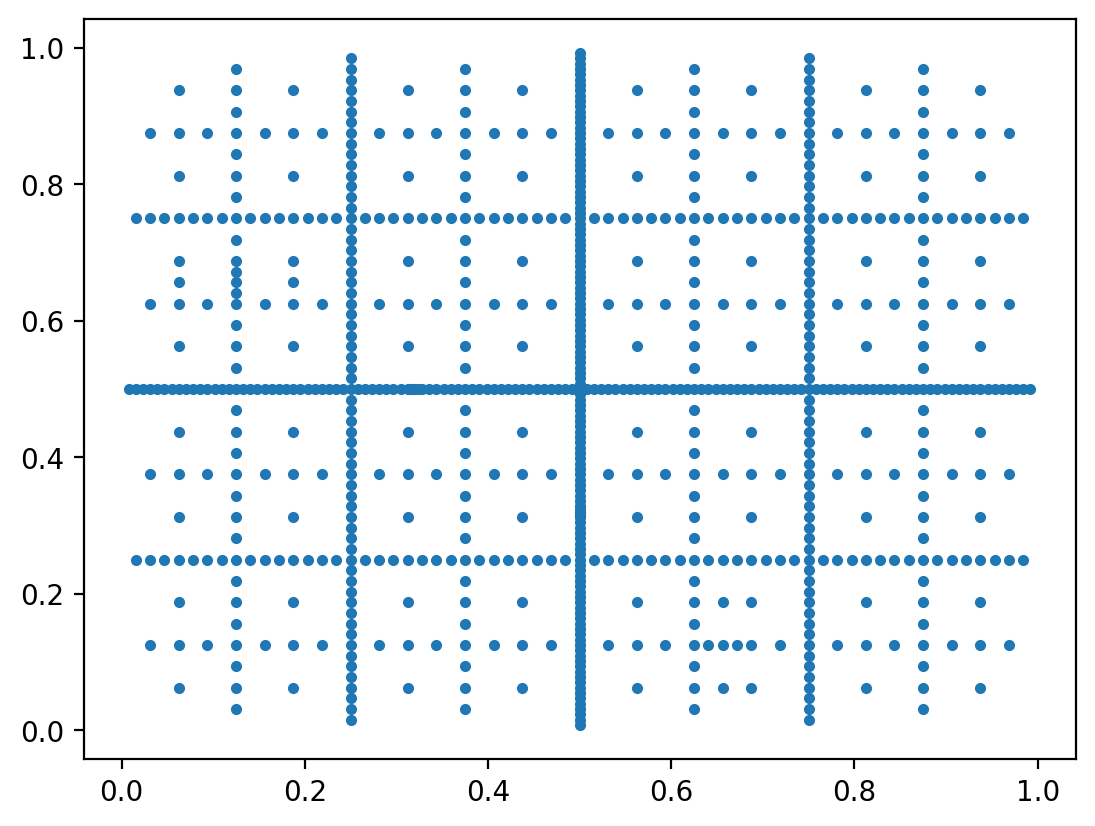

In [2]:
import matplotlib.pyplot as plt
print("length of alpha vector:           {}".format(alpha.getSize()))

print(type(alpha))

print(HashGridStorage.getSize())

x0 = []
x1 = []
y = alpha
x_train = []
for i in range(HashGridStorage.getSize()):
    gp = HashGridStorage.getPoint(i)
    x0.append(gp.getStandardCoordinate(0))
    x1.append(gp.getStandardCoordinate(1))
    x_train.append([gp.getStandardCoordinate(0),gp.getStandardCoordinate(1)])
    # opEval = createOperationEval(grid)
    # vec = DataVector(0)
    # vec.append(gp.getStandardCoordinate(0))
    # vec.append(gp.getStandardCoordinate(1))
    # print('vec', vec)
    # print('function value', f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1)))
    # print('opEval', opEval.eval(alpha,vec))
    
    # error[i] = pow(f(dataSet.get(i,0),dataSet.get(i,1))-opEval.eval(alpha,vec),2)
plt.figure(dpi=200)
plt.plot(x0,x1, '.')

print(len(x0))

In [3]:
print(len(x_train))
print(len(alpha))

789
789


In [4]:
from GENE_ML.gene_ml.models.GPR import GPR
gpr = GPR(name='gpr_ssg_points_gt')
gpr.tune_hypers(x=x_train, y=alpha)

: 

# Compare true function with interpolant

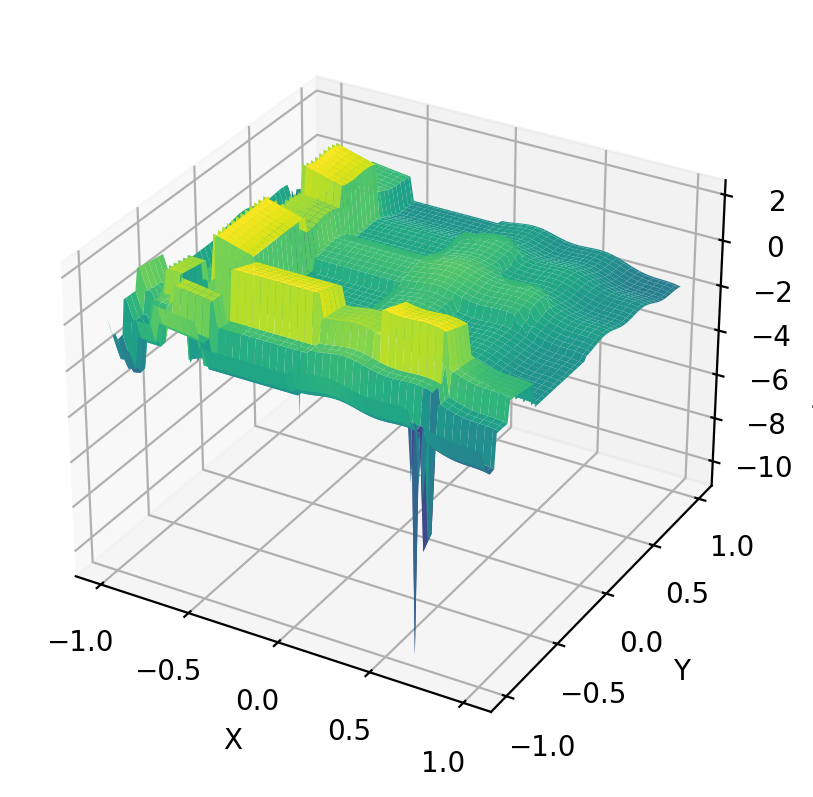

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def cosineMixture_OpEval(X, grid, alpha):
    vec = DataVector(0)
    vec.append(X[0])
    vec.append(X[1])
    opEval = createOperationEval(grid)
    z = opEval.eval(alpha,vec)
    return z 

cosineMixture = lambda X: cosineMixture_OpEval(X, grid=grid, alpha=alpha)

# Generate 2D input data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([cosineMixture(np.array([xi, yi])) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

# Create a 3D mesh plot
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set plot labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('cosineMixture(X, Y)')

# Show plot
plt.show()



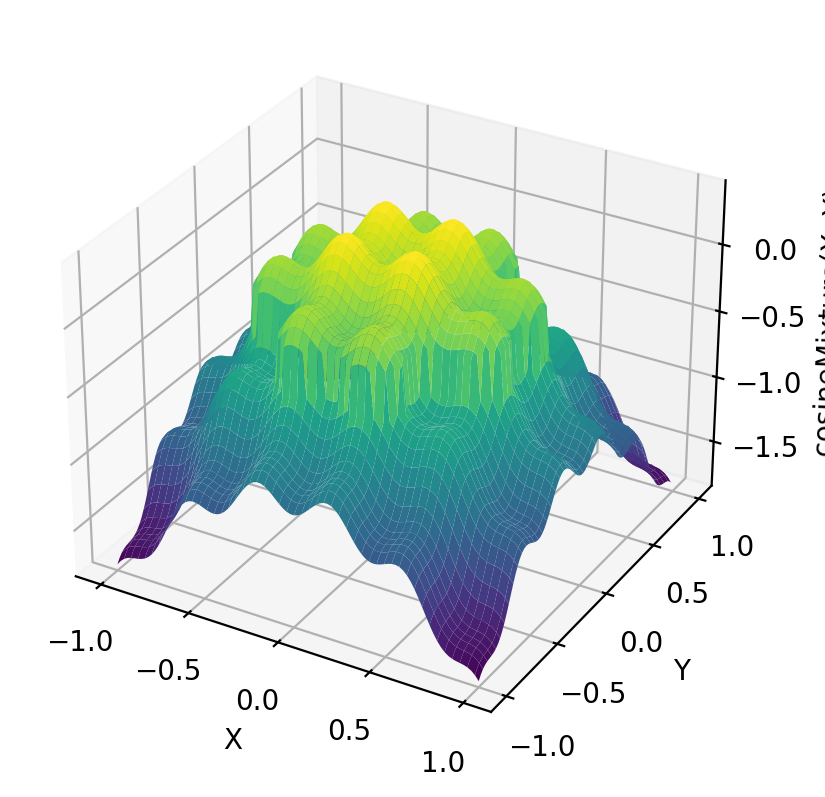

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def cosineMixture(X, slant_grad = 0):
    z = -0.1*np.sum(np.cos(5*np.pi*X)) - np.sum(X**2)
    step = np.where(z>-0.4, 0.3, 0)
    slant = 0
    # if z <-0.3:
    #     slant = slant_grad * np.sqrt(np.sum(x**2)) -2
    z = z+step+slant
    return z 


# Generate 2D input data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([cosineMixture(np.array([xi, yi])) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

# Create a 3D mesh plot
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set plot labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('cosineMixture(X, Y)')

# Show plot
plt.show()



In [4]:
from GENE_ML.gene_ml.models.GPR import GPR
import numpy as np
x_d = [np.array((x[0],x[1])) for x in zip(x0,x1)]
y_d = np.array(alpha)
gpr = GPR(name='sgpp')

print(x_d)
print(y_d)
# gpr.fit(x_d, y_d)

# Plot Grid

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__weakref__', 'assign', 'equals', 'get', 'getDimension', 'getHash', 'getIndex', 'getLeftBoundaryPoint', 'getLeftChild', 'getLeftLevelZero', 'getLevel', 'getLevelMax', 'getLevelMin', 'getLevelSum', 'getParent', 'getRightBoundaryPoint', 'getRightChild', 'getRightLevelZero', 'getRoot', 'getStandardCoordinate', 'getStandardCoordinates', 'isHierarchicalAncestor', 'isInnerPoint', 'isLeaf', 'push', 'rehash', 'serialize', 'set', 'setAsHierarchicalGridPoint', 'setLeaf', 'this', 'thisown', 'toString']


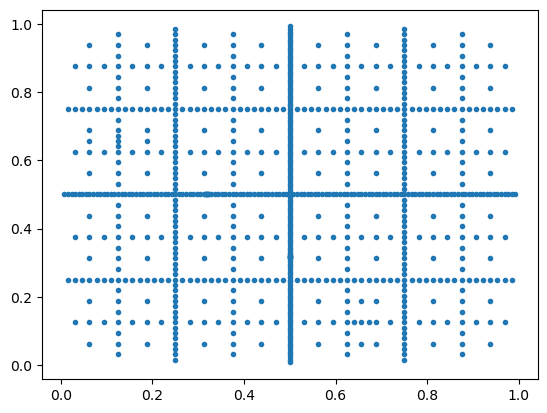

In [8]:
import matplotlib.pyplot as plt
GP = []
for i in range(HashGridStorage.getSize()):
    GP.append(HashGridStorage.getPoint(i))


print(dir(GP[10]))

x0 = []
x1 = []
for gp in GP:
    x0.append(gp.getStandardCoordinate(0))
    x1.append(gp.getStandardCoordinate(1))
plt.plot(x0,x1, '.')